# False clouds in ABI static features

Clouds that do not move or evolve are more likely to be false clouds. This program overlays ABI imagery in order to see which features do not evolve with time. 

ABI data is from /mnt/grb/goes16/ on smiller2

In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from sklearn.preprocessing import normalize
import fnmatch
import pickle
import timeit

In [2]:
#--- Filter to the region

#---Georges Bank
min_lon = -70.5
min_lat = 39
max_lon = -67
max_lat = 43

## Visualizing a specific time

In [3]:
date = '20231112'

nlct_path = "/mnt/data2/jturner/nlct_data/georges_bank/"+date+"/"

filename = 'goes_e_ntlc_'+date[0:4]+'_'+date[4:6]+'_'+date[6:8]+'_00H_00M'

In [4]:
file = open(nlct_path+filename, 'rb')
BTD = pickle.load(file)
file.close()

Filter the NLCT to the region of interest:

In [5]:
BTD_c = BTD.where((BTD.lat>min_lat) & (BTD.lat<max_lat) & (BTD.lon>min_lon) & (BTD.lon<max_lon))
BTD_c = BTD_c.dropna(dim="y", how="all")
BTD_c = BTD_c.dropna(dim="x", how="all")

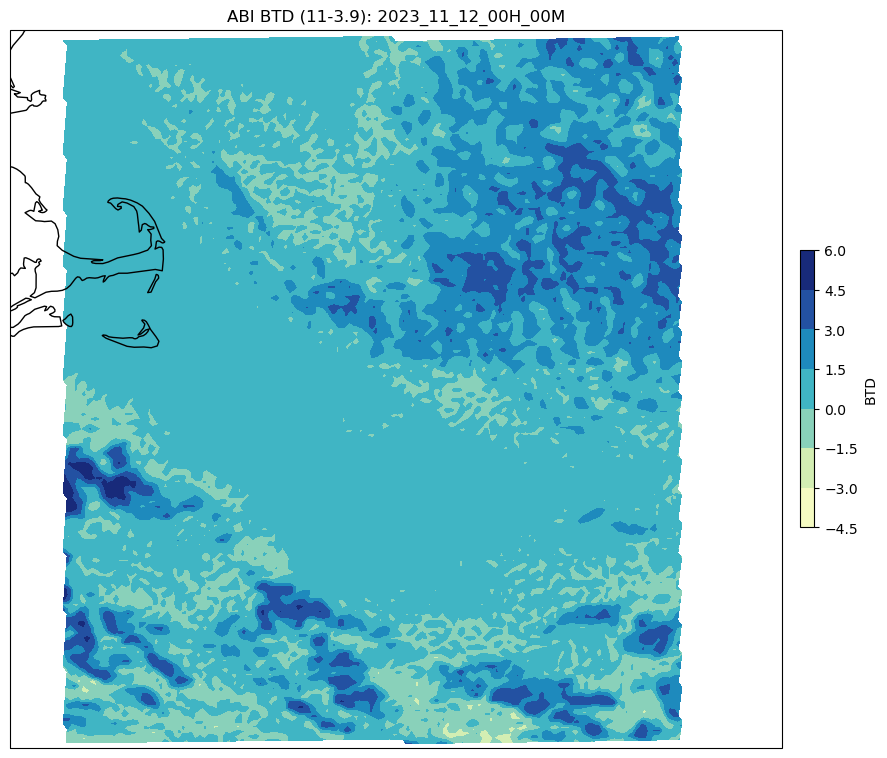

In [6]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlGnBu
#levels = np.linspace(0, np.amax(BTD), 31)

c=ax.contourf(BTD_c.lon, BTD_c.lat, BTD_c[0], cmap=cmap) #levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('ABI BTD (11-3.9): ' + filename[12:])
clb.set_label('BTD')

ax.add_feature(cfeature.STATES)

## Combining the range of times

Definiting the static features function:

In [7]:
def get_static_features(BTD_c, nlct_path):
    #--- Initialize an array of 1's in the shape of the final image
    BTD_prod = [ [1]*len(BTD_c[0][0]) for i in range(len(BTD_c[0]))]

    #--- Starting the timer
    starttime = timeit.default_timer()

    #--- Include all times or just top of hour (TOH)
    all_files = sorted(os.listdir(nlct_path))
    toh_files = [filename for filename in all_files if filename.endswith('00M')]

    for filename in toh_files:
            print(filename)

            #--- Open the NLCT file
            file = open(nlct_path+filename, 'rb')
            BTD = pickle.load(file)
            file.close()

            #--- Crop to the specified region
            BTD = BTD.where((BTD.lat>min_lat) & (BTD.lat<max_lat) & (BTD.lon>min_lon) & (BTD.lon<max_lon))
            BTD = BTD.dropna(dim="y", how="all")
            BTD = BTD.dropna(dim="x", how="all")

            #--- Set negative values to zero
            BTD = np.where(BTD < 0, 0, BTD)

            #--- V1: Multiply to only enhance static clouds
            #BTD_prod = BTD_prod*BTD

            #--- V1: Limit runaway large values to 3
            #BTD_prod = np.where(BTD_prod > 3, 3, BTD_prod)
            
            #--- V2: Sum to enhance static clouds
            BTD_prod = BTD_prod+BTD


    print("Completed: ", timeit.default_timer() - starttime)

    return BTD_prod

Running the static features function for the date of choice:

In [8]:
BTD_prod = get_static_features(BTD_c, nlct_path)

goes_e_ntlc_2023_11_12_00H_00M
goes_e_ntlc_2023_11_12_01H_00M
goes_e_ntlc_2023_11_12_02H_00M
goes_e_ntlc_2023_11_12_03H_00M
goes_e_ntlc_2023_11_12_04H_00M
goes_e_ntlc_2023_11_12_05H_00M
goes_e_ntlc_2023_11_12_06H_00M
goes_e_ntlc_2023_11_12_07H_00M
goes_e_ntlc_2023_11_12_08H_00M
Completed:  0.07119167596101761


V2 processing of summed BTD (do not run for V1):
* not working yet

In [9]:
#--- V2: Limit to top 25%
# BTD_prod = np.nan_to_num(BTD_prod, nan=0)
# BTD_prod = BTD_prod/np.max(BTD_prod)
# limit = 0.75
# BTD_prod = np.where(BTD_prod < limit, 0, BTD_prod)
# BTD_prod = np.where(BTD_prod > limit, 1, BTD_prod)

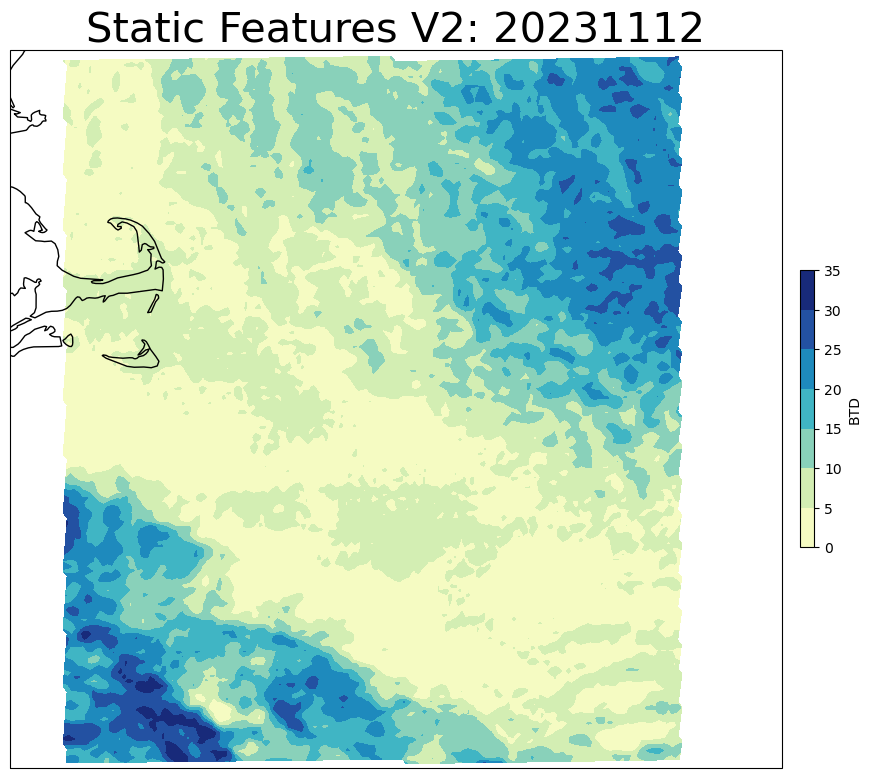

In [10]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlGnBu
#levels = np.linspace(0, 3, 31)
#levels = np.linspace(0, 1, 11)

c=ax.contourf(BTD_c.lon, BTD_c.lat, BTD_prod[0], cmap=cmap)#, levels=levels, extend='neither')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Static Features V2: '+date, fontsize=30)
clb.set_label('BTD')

ax.add_feature(cfeature.STATES)

## Static features over two nights

Including the next date from the one chosen:

In [11]:
date2 = str(int(date)+1)
date2

'20231113'

In [12]:
nlct_path2 = "/mnt/data2/jturner/nlct_data/georges_bank/"+date2+"/"

BTD_prod2 = get_static_features(BTD_c, nlct_path2)

goes_e_ntlc_2023_11_13_00H_00M
goes_e_ntlc_2023_11_13_01H_00M
goes_e_ntlc_2023_11_13_02H_00M
goes_e_ntlc_2023_11_13_03H_00M
goes_e_ntlc_2023_11_13_04H_00M
goes_e_ntlc_2023_11_13_05H_00M
goes_e_ntlc_2023_11_13_06H_00M
goes_e_ntlc_2023_11_13_07H_00M
goes_e_ntlc_2023_11_13_08H_00M
Completed:  0.07096745818853378


In [13]:
BTD_tot = BTD_prod + BTD_prod2

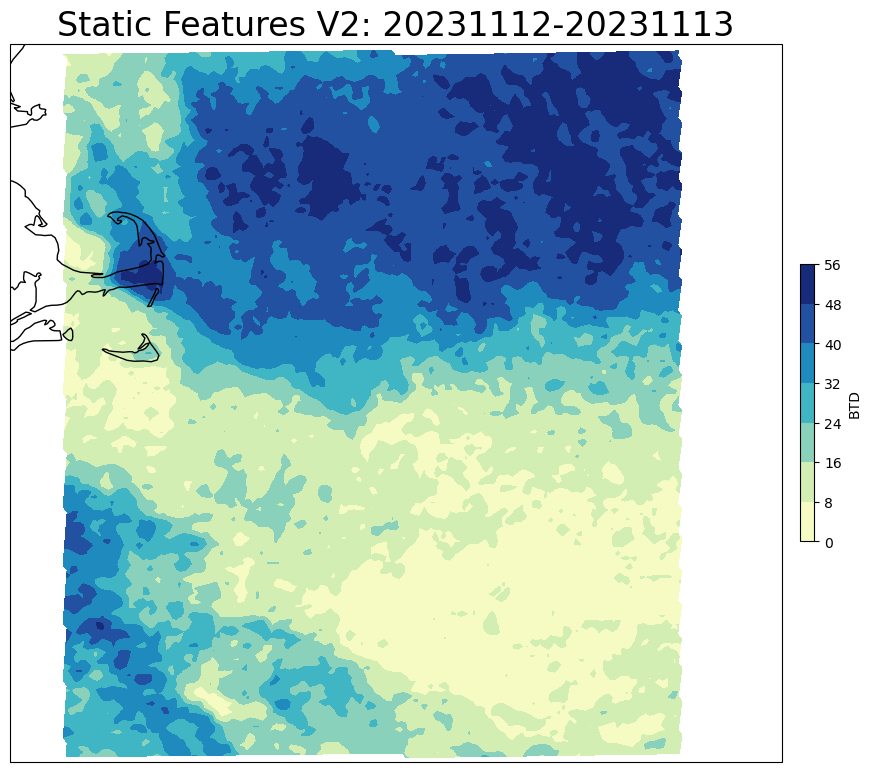

In [14]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlGnBu
#levels = np.linspace(0, 3, 31)
#levels = np.linspace(0, 1, 11)

c=ax.contourf(BTD_c.lon, BTD_c.lat, BTD_tot[0], cmap=cmap)#, levels=levels, extend='neither')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Static Features V2: '+date+'-'+date2, fontsize=24)
clb.set_label('BTD')

ax.add_feature(cfeature.STATES)

In [15]:
#--- V2: Limit to top 25%
BTD_tot_lim = np.nan_to_num(BTD_tot, nan=0)
BTD_tot_lim = BTD_tot_lim/np.max(BTD_tot_lim)
limit = 0.75
BTD_tot_lim = np.where(BTD_tot_lim < limit, 0, BTD_tot_lim)
BTD_tot_lim = np.where(BTD_tot_lim > limit, 1, BTD_tot_lim)

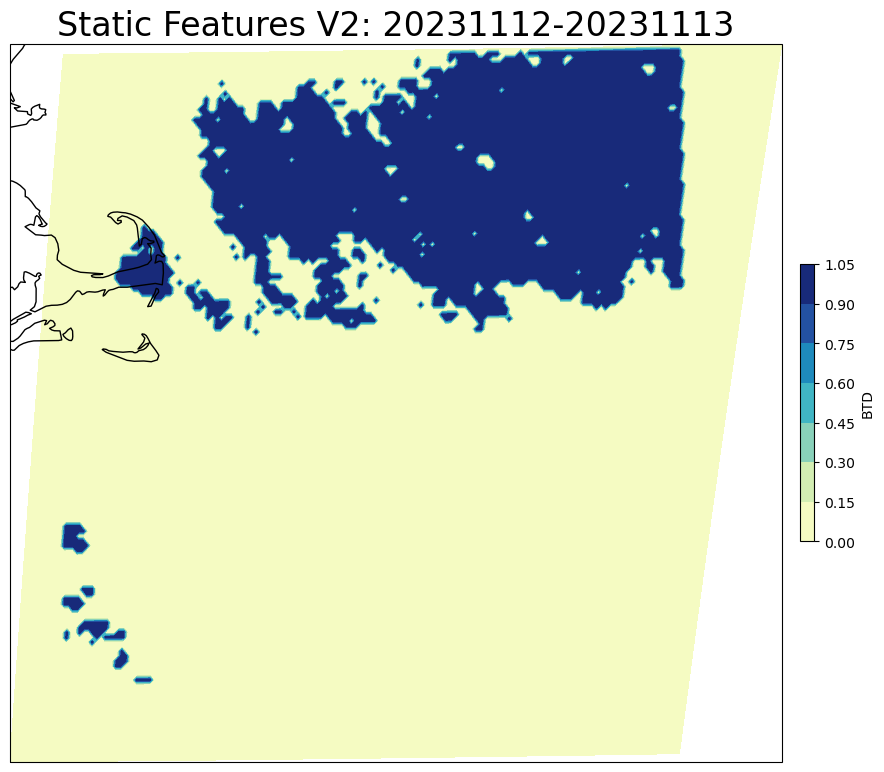

In [16]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlGnBu
#levels = np.linspace(0, 3, 31)
#levels = np.linspace(0, 1, 11)

c=ax.contourf(BTD_c.lon, BTD_c.lat, BTD_tot_lim[0], cmap=cmap)#, levels=levels, extend='neither')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Static Features V2: '+date+'-'+date2, fontsize=24)
clb.set_label('BTD')

ax.add_feature(cfeature.STATES)

In [17]:
static_value = np.nansum(BTD_tot_lim)
static_value

4346.0